In [2]:
### RUN THIS
import pandas as pd

In [58]:
# Load data file
df = pd.read_csv('censo2ok.csv', sep = ';')
df.head()

# Drop unwanted columns
df = df.drop('telefone', axis=1)

# Drop unwanted states
df = df[df.endereco_uf == 'RN']

In [64]:
import numpy as np

# Compute full address
def compute_full_address(row):
    # Address type
    addr_type = row['tipoendereco']

    if (not isinstance(addr_type, str)) and np.isnan(addr_type):
        addr_type = ''

    result = addr_type

    # Street, avenue, etc.
    addr_name = row['endereco_logradouro']

    if len(result) > 0:
        result += ' '

    result += addr_name

    # Number
    addr_num = row['endereco_numero']

    if np.isnan(addr_num):
        addr_num = ''

    if not isinstance(addr_num, str):
        addr_num = str(addr_num)

    if len(result) > 0:
        result += ', '

    result += addr_num

    # Neighborhood
    neigh = row['endereco_bairro']

    if (not isinstance(neigh, str)) and np.isnan(neigh):
        neigh = ''

    if not isinstance(neigh, str):
        neigh = str(neigh)

    if len(neigh) > 0:
        if len(result) > 0:
            result += ', '

        result += neigh

    # City
    city = row['endereco_cidade']

    if len(city) > 0:
        if len(result) > 0:
            result += ', '

        result += city

    # Country
    if len(result) > 0:
        result += ', '

    result += 'Brasil'

    return result.upper()

df['full_address'] = df.apply(compute_full_address, axis=1)

print('Done!')

Done!


In [21]:
### RUN THIS
import googlemaps

### TYPE YOUR GOOGLE MAPS API KEY HERE
gmaps = googlemaps.Client(key='???', timeout=30)

In [47]:
### RUN THIS
from time import sleep
from random import randint
from time import time
from IPython.core.display import clear_output
from warnings import warn

import numpy as np

In [67]:
df['time_to_hospital'] = df.apply(lambda row : '-1', axis=1)
df['distance_to_hospital'] = df.apply(lambda row : '-1', axis=1)
df['time_distance_to_hospital'] = df.apply(lambda row : '-1/-1', axis=1)

print('Done!')

Done!


In [3]:
### RUN THIS

# Reload data file
df = pd.read_csv('censo2ok-comdist.csv', sep = ',')
#df.head()

In [22]:
### RUN THIS

def calc_time_distance_to_hospital(row):
    origin = row['full_address']
    destination = 'Avenida Nilo Peçanha, 259, Petrópolis, Natal, Brasil'  # Januário Cicco

    dist_matrix = gmaps.distance_matrix( \
        origins=origin, destinations=destination, \
        mode='driving', language='english', units='metric')

    if (dist_matrix is None) or (not isinstance(dist_matrix, dict)):
        return '-1/-1'

    if dist_matrix['status'] != 'OK':
        return '-1/-1'

    try:
        dist_rows = dist_matrix['rows']  # Array
        dist_elems = dist_rows[0]['elements']  # Array

        elem_dur = dist_elems[0]['duration']  # Dict
        time_to_hosp = elem_dur['value']
        print('TTH: ' + str(time_to_hosp))

        elem_dist = dist_elems[0]['distance']  # Dict
        dist_to_hosp = elem_dist['value']
        print('DTH: ' + str(dist_to_hosp))

        return str(time_to_hosp) + '/' + str(dist_to_hosp)
    except:
        return '-1/-1'

last_processed_row = -1

for i, row in df.iterrows():
    # Process only rows 2414-8246
    if i < 2414 or i > 8246:
        continue

    last_processed_row = i

    time_dist = calc_time_distance_to_hospital(row)
    df.set_value(i, 'time_distance_to_hospital', time_dist)

    # ATTENTION If we're processing for a full day, we should
    #           wait at least 35 seconds here (86400 / 2500)
    print('Request: {}'.format(i))
    clear_output(wait = True)

    sleep(randint(35, 37))

print('Last processed row: ' + str(last_processed_row))
print('Done!')

KeyboardInterrupt: 

In [68]:
#print(df.iloc[0])
df['time_distance_to_hospital'].unique()

array(['-1/-1'], dtype=object)

In [23]:
### RUN THIS

df.to_csv('censo2ok-comdist.csv')
print('Done!')

Done!


In [8]:
from datetime import datetime

date_obj_1 = datetime.strptime('28/11/2016 08:51:40', '%d/%m/%Y %H:%M:%S')
date_obj_2 = datetime.strptime('28/11/2017 08:51:40', '%d/%m/%Y %H:%M:%S')
delta = date_obj_2 - date_obj_1

print(date_obj_1)
print(date_obj_2)
print('Days diff: ' + str(delta.days))
print('Seconds diff: ' + str(delta.seconds))

2016-11-28 08:51:40
2017-11-28 08:51:40
Day diff: 365
Second diff: 0


In [4]:
# Reload data file
df = pd.read_csv('censo2ok-comdist-4-2.csv', sep = ',')
#df.head(1)

In [41]:
df['hospital_wait_time'] = df.apply(lambda row : '-1', axis=1)
df['hospital_service_time'] = df.apply(lambda row : '-1', axis=1)

for i, row in df.iterrows():
    #if i < 0 or i > 4:
    #    continue

    tdh_items = row['time_distance_to_hospital'].split('/', 2)
    #print(tdh_items[0] + ' / ' + tdh_items[1])

    wait_time = -1
    service_time = -1

    try:
        arrival_time = datetime.strptime(row['chegada'], '%d/%m/%Y %H:%M:%S')
        service_start = datetime.strptime(row['inicio'], '%d/%m/%Y %H:%M:%S')
        wait_delta = service_start - arrival_time
        wait_time = wait_delta.days * 86400 + wait_delta.seconds

        service_end = datetime.strptime(row['fim'], '%d/%m/%Y %H:%M:%S')
        service_delta = service_end - service_start
        service_time = service_delta.days * 86400 + service_delta.seconds
    except:
        pass

    #print('   ' + str(wait_time) + ' # ' + str(service_time))

    df.set_value(i, 'time_to_hospital', int(tdh_items[0]))
    df.set_value(i, 'distance_to_hospital', int(tdh_items[1]))
    df.set_value(i, 'hospital_wait_time', int(wait_time))
    df.set_value(i, 'hospital_service_time', int(service_time))

print('Done!')

Done!


In [42]:
df = df.drop('time_distance_to_hospital', axis=1)
#df = df.drop('full_address', axis=1)
df = df.drop('telefone', axis=1)

df.to_csv('censo2ok-comdist-6.csv')
print('Done!')

Done!


In [85]:
# KNN estimates section

In [46]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# Reload data file
df = pd.read_csv('censo2ok-comdist-6.csv', sep = ',')
#df.head(1)

# Drop unwanted rows
df = df[df.time_to_hospital > 0]
df = df[df.distance_to_hospital > 0]
df = df[df.hospital_wait_time > 0]
df = df[df.hospital_service_time > 0]
df = df[df.Other_Hospital != ""]
#df = df[df.endereco_cidade == "NATAL"]

#df.info()
row_count = df.shape[0]
print('Row count: ' + str(row_count))
train_count = int(row_count * 3 / 4)

# Include new columns
df['time_to_hospital_norm'] = df.apply(lambda row : '-1', axis=1)
df['distance_to_hospital_norm'] = df.apply(lambda row : '-1', axis=1)
df['time_to_Other_Hospital_norm'] = df.apply(lambda row : '-1', axis=1)
df['distance_to_Other_Hospital_norm'] = df.apply(lambda row : '-1', axis=1)
df['Other_Hospital_wait_time'] = df.apply(lambda row : '-1', axis=1)
df['Other_Hospital_service_time'] = df.apply(lambda row : '-1', axis=1)

# Normalize attributes
mean_value = df['time_to_hospital'].mean()
std_value = df['time_to_hospital'].std()
normalized_col = (df['time_to_hospital'] - mean_value) / std_value
df['time_to_hospital_norm'] = normalized_col

mean_value = df['distance_to_hospital'].mean()
std_value = df['distance_to_hospital'].std()
normalized_col = (df['distance_to_hospital'] - mean_value) / std_value
df['distance_to_hospital_norm'] = normalized_col

mean_value = df['time_to_Other_Hospital'].mean()
std_value = df['time_to_Other_Hospital'].std()
normalized_col = (df['time_to_Other_Hospital'] - mean_value) / std_value
df['time_to_Other_Hospital_norm'] = normalized_col

mean_value = df['distance_to_Other_Hospital'].mean()
std_value = df['distance_to_Other_Hospital'].std()
normalized_col = (df['distance_to_Other_Hospital'] - mean_value) / std_value
df['distance_to_Other_Hospital_norm'] = normalized_col

# Generate training and testing dataframes
train_df = df.iloc[0:train_count]
test_df = df.iloc[train_count:]

print('Done!')


Row count: 5713
Done!


In [107]:
#features_to_use = ['time_to_hospital', \
#    'distance_to_hospital', 'hospital_wait_time', 'hospital_service_time']

#knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')
#knn.fit(train_df[features_to_use], train_df['hospital_service_time'])
#predictions = knn.predict(test_df[features_to_use])
#mse = mean_squared_error(test_df['hospital_service_time'], predictions)

#print(predictions)
#print('MSE: '+ str(mse))

# Estimate wait time
hyper_params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, \
                11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

best_k = 0
best_mse = 0

features_1 = ['time_to_hospital_norm', 'distance_to_hospital_norm', \
    'hospital_wait_time', 'hospital_service_time']

for i, hyper in enumerate(hyper_params):
    knn = KNeighborsRegressor(n_neighbors=hyper, algorithm='brute')
    knn.fit(train_df[features_1], train_df['hospital_wait_time'])
    predictions = knn.predict(test_df[features_1])
    mse = mean_squared_error(test_df['hospital_wait_time'], predictions)
    if (best_k == 0) or (mse < best_mse):
        best_k = hyper
        best_mse = mse

print('Wait time - Best K: ' + str(best_k))
print('Wait time - Best MSE: '+ str(best_mse))

features_2 = ['time_to_Other_Hospital_norm', 'distance_to_Other_Hospital_norm', \
    'hospital_wait_time', 'hospital_service_time']

knn = KNeighborsRegressor(n_neighbors=best_k, algorithm='brute')
knn.fit(df[features_1], df['hospital_wait_time'])
predictions = knn.predict(df[features_2])
df['Other_Hospital_wait_time'] = [int(x) for x in predictions]

# Estimate service time
best_k = 0
best_mse = 0

features_1 = ['time_to_hospital_norm', 'distance_to_hospital_norm', \
    'hospital_wait_time', 'hospital_service_time']

for i, hyper in enumerate(hyper_params):
    knn = KNeighborsRegressor(n_neighbors=hyper, algorithm='brute')
    knn.fit(train_df[features_1], train_df['hospital_service_time'])
    predictions = knn.predict(test_df[features_1])
    mse = mean_squared_error(test_df['hospital_service_time'], predictions)
    if (best_k == 0) or (mse < best_mse):
        best_k = hyper
        best_mse = mse

print('Service time - Best K: ' + str(best_k))
print('Service time - Best MSE: '+ str(best_mse))

features_2 = ['time_to_Other_Hospital_norm', 'distance_to_Other_Hospital_norm', \
    'hospital_wait_time', 'hospital_service_time']

knn = KNeighborsRegressor(n_neighbors=best_k, algorithm='brute')
knn.fit(df[features_1], df['hospital_service_time'])
predictions = knn.predict(df[features_2])
df['Other_Hospital_service_time'] = [int(x) for x in predictions]

df = df.drop('time_to_hospital_norm', axis=1)
df = df.drop('distance_to_hospital_norm', axis=1)
df = df.drop('time_to_Other_Hospital_norm', axis=1)
df = df.drop('distance_to_Other_Hospital_norm', axis=1)


Wait time - Best K: 7
Wait time - Best MSE: 36755.0612531
Service time - Best K: 2
Service time - Best MSE: 1163619.35777


In [ ]:
df.to_csv('censo2ok-comdist-7.csv')
print('Done!')

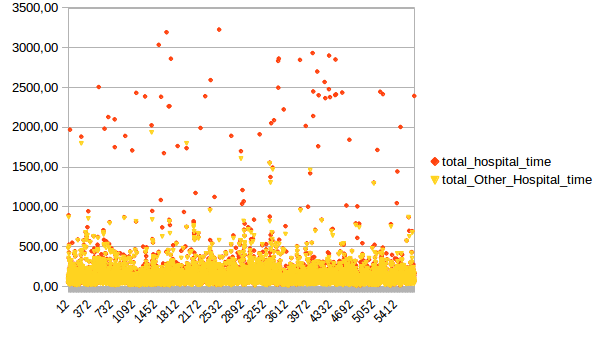

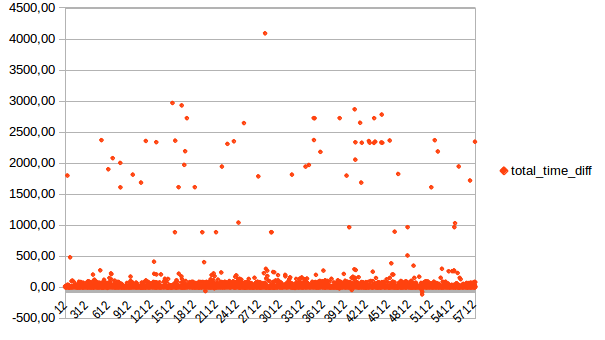